 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [08/Sep/2023 11:32:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2023 11:32:56] "GET /static/background.jpg HTTP/1.1" 304 -
127.0.0.1 - - [08/Sep/2023 11:32:56] "GET /favicon.ico HTTP/1.1" 404 -


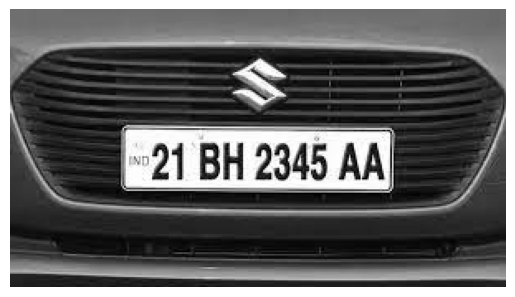

127.0.0.1 - - [08/Sep/2023 11:33:05] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2023 11:33:05] "GET /static/background.jpg HTTP/1.1" 304 -


License Plate: 21BH2345AA


127.0.0.1 - - [08/Sep/2023 11:33:07] "GET /get-details?license_number=%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%2021BH2345AA&license_number= HTTP/1.1" 200 -


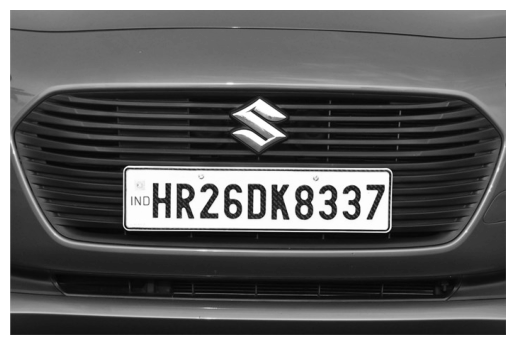

127.0.0.1 - - [08/Sep/2023 11:33:54] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2023 11:33:54] "GET /static/background.jpg HTTP/1.1" 304 -


License Plate: HR26DK8337


In [ ]:
import sqlite3
import base64
import cv2
import pytesseract
import matplotlib.pyplot as plt
from flask import Flask, render_template, request, jsonify
import os
import re
import webbrowser
import threading

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
app = Flask(__name__)

recognized_text = []

def extract_alphanumeric(text):
    alphanumeric = re.sub(r'\W+', '', text)
    return alphanumeric

@app.route('/', methods=['GET', 'POST'])
def index():
    global recognized_text

    if request.method == 'POST':
        file = request.files['file']
        if file:
            file_path = os.path.join("car.jpeg")
            file.save(file_path)

            img = cv2.imread(file_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            cascade = cv2.CascadeClassifier("licenseplaterecognition.xml")
            plates = cascade.detectMultiScale(gray, 1.2, 5)

            recognized_text = []

            for (x, y, w, h) in plates:
                plate_img = gray[y:y+h, x:x+w]
                plate_text = pytesseract.image_to_string(plate_img, config='--psm 6')
                plate_text = extract_alphanumeric(plate_text)
                recognized_text.append(plate_text)
                plt.imshow(gray, cmap='gray')
                plt.axis('off')
                plt.show()

                print("License Plate:", plate_text)

            # Display the grayscale image in the notebook using matplotlib
            
    return render_template('index.html', text=recognized_text)



@app.route('/get-details')
def get_details():
    conn = sqlite3.connect('alpr.db')
    cursor = conn.cursor()

    license_numbers = recognized_text

    details = []
    for license_number in license_numbers:
        query = "SELECT * FROM information WHERE license_number LIKE ?"
        plate_text = f'%{license_number}%'
        cursor.execute(query, (plate_text,))
        rows = cursor.fetchall()

        for row in rows:
            detail = {
                'license_number': row[0],
                'chassis_number': row[1],
                'engine_number': row[2],
                'car_company': row[3],
                'car_model': row[4],
                'year of manufacture': row[5],
                'owner name': row[6],
                'phone number': row[7],
                'Address': row[8],
                'image': None  # Initialize image to None
            }

            # Read the image file from the path and encode it to base64
            if row[9]:  # Assuming the image path is stored in the 10th column (index 9)
                with open(row[9], 'rb') as img_file:
                    image_data = img_file.read()
                    image_base64 = base64.b64encode(image_data).decode('utf-8')
                    detail['image'] = image_base64

            details.append(detail)

    conn.close()

    if not details:
        return jsonify({'message': 'NO MATCHING RECORDS FOUND, FAKE NUMBER PLATE!.'})
    else:
        return jsonify(details)
def open_browser():
    webbrowser.open('http://localhost:5000')

if __name__ == '__main__':
    threading.Timer(1, open_browser).start()
    app.run()